# Predict Discount Based on Age

In [10]:
from random import randrange, choice
import os
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split


## Create Data

In [13]:
sample_size =100000
data_file = f'../data/discount_data_{sample_size}.xlsx'

business_list = ['bar', 'restaurant', 'hotel', 'pharmacy', 'spa', 'airline']


def calculate_discount(age, sex, business_type, is_resident):
    business_discounts = dict()
    business_discounts['restaurant'] = 0.2
    business_discounts['pharmacy'] = 0.2
    business_discounts['hotel'] = 0.25
    
    if sex == 'M' and age >= 64 and is_resident:
        return business_discounts.get(business_type, 0.0)
    elif sex == 'F' and age >= 57 and is_resident:
        return business_discounts.get(business_type, 0.0)
    else:
        return 0.0
    
def build_dataframe(samples):

    data = dict()
    data['sex'] = list()
    data['age'] = list()
    data['business_type'] = list()
    data['discount'] = list()
    data['is_resident'] = list()
    for i in range(samples):
        age = randrange(18, 95, 1)
        sex = choice(['M', 'F'])
        business_type = choice(business_list)
        is_resident =  choice([True, False])
        discount = calculate_discount(age, sex, business_type, is_resident)
        print(f'{i} {sex} age {age} for {business_type}', end='\r')
        data['sex'].append(sex)
        data['age'].append(age)
        data['business_type'].append(business_type)
        data['discount'].append(discount)
        data['is_resident'].append(is_resident)
        df = pd.DataFrame.from_dict(data)
    return df
    


In [14]:
if os.path.exists(data_file):
    df = pd.read_excel(data_file)
    print(f'Loaded from {data_file}')
else:
    df = build_dataframe(sample_size)
    df.to_excel(data_file, index=False)
    print(f'Saved to {data_file}')

Saved to ../data/discount_data_100000.xlsx


In [15]:
print(f'Shape: {df.shape}')
df.head()

Shape: (100000, 5)


,sex,age,business_type,discount,is_resident
0,M,88,bar,0.0,True
1,M,48,hotel,0.0,True
2,F,32,pharmacy,0.0,True
3,M,74,pharmacy,0.2,True
4,M,36,restaurant,0.0,False


## Cleanup


### Separate dependent and independent variables

In [16]:
discounts = df['discount'].copy()
df.drop(columns=['discount',], inplace=True)

print(f'discount shape: {discounts.shape}')

df.head()

discount shape: (100000,)


,sex,age,business_type,is_resident
0,M,88,bar,True
1,M,48,hotel,True
2,F,32,pharmacy,True
3,M,74,pharmacy,True
4,M,36,restaurant,False


### Hot One Encode

In [17]:
df = pd.get_dummies(df, columns=['business_type'])


In [18]:
df['is_resident'].replace({False: 0, True: 1}, inplace=True)

df['sex'] = df['sex'].replace({'M': 1, 'F': 0})

df["sex"] = pd.to_numeric(df["sex"])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   sex                       100000 non-null  int64
 1   age                       100000 non-null  int64
 2   is_resident               100000 non-null  int64
 3   business_type_airline     100000 non-null  uint8
 4   business_type_bar         100000 non-null  uint8
 5   business_type_hotel       100000 non-null  uint8
 6   business_type_pharmacy    100000 non-null  uint8
 7   business_type_restaurant  100000 non-null  uint8
 8   business_type_spa         100000 non-null  uint8
dtypes: int64(3), uint8(6)
memory usage: 2.9 MB


### Scaling age

In [20]:
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


In [21]:
print(f'Shape: {df.shape}')
df.head()

Shape: (100000, 9)


,sex,age,is_resident,business_type_airline,business_type_bar,business_type_hotel,business_type_pharmacy,business_type_restaurant,business_type_spa
0,1,0.921053,1,0,1,0,0,0,0
1,1,0.394737,1,0,0,1,0,0,0
2,0,0.184211,1,0,0,0,1,0,0
3,1,0.736842,1,0,0,0,1,0,0
4,1,0.236842,0,0,0,0,0,1,0


### Split Training and Test Data

In [22]:

X_train, X_test, y_train, y_test = train_test_split(df.values, discounts.values,
                                                    test_size=0.2, random_state=25)

print('Train', X_train.shape, y_train.shape)
print('Test',X_test.shape, y_test.shape)

Train (80000, 9) (80000,)
Test (20000, 9) (20000,)


## Basic Neuronal Network


https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [23]:
learning_rate = 0.001

#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [24]:
model = tf.keras.models.Sequential()
print(X_train.shape[1])
model.add(Dense(X_train.shape[1], kernel_initializer='normal',
                input_dim = X_train.shape[1],
                activation='relu'))

model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))


9


In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error', 'accuracy']
)

In [26]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=32, validation_split = 0.2,
                   verbose=False)
                    #callbacks=callbacks_list))

In [27]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'accuracy', 'val_loss', 'val_mean_absolute_error', 'val_accuracy'])


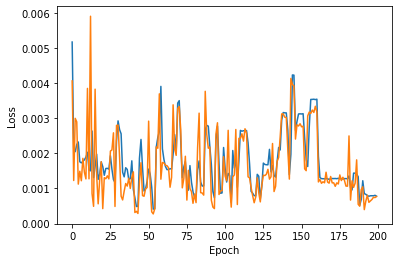

In [28]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

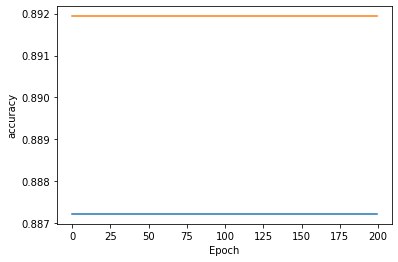

In [29]:
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

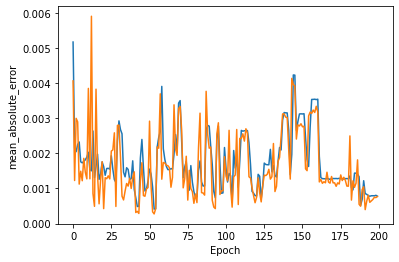

In [30]:
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()

In [31]:
#df_values = df.values
#disc_value = discounts.values
#print(y_test)
c = 1
i = 0
for discount in y_test:
    if discount > 0.0:
        print(i, discount)
        c += 1
    if c == 10:
        break
    i += 1
        
print('>>',y_test[51])

0 0.25
9 0.25
10 0.25
19 0.2
21 0.25
36 0.2
51 0.2
54 0.2
73 0.25
>> 0.2


In [32]:
t = 51
print(df.columns)
print(X_test[t])
print(y_test[t])

Index(['sex', 'age', 'is_resident', 'business_type_airline',
       'business_type_bar', 'business_type_hotel', 'business_type_pharmacy',
       'business_type_restaurant', 'business_type_spa'],
      dtype='object')
[1.         0.68421053 1.         0.         0.         0.
 1.         0.         0.        ]
0.2


In [33]:
pred = model.predict(X_test) #.reshape(10,1))
#print(type(pred))
print(f'Estimated discount {pred[t]}')

Estimated discount [0.19930069]


In [34]:


print(f'Estimated discount {pred[3]}')

Estimated discount [-8.0541125e-05]


In [35]:

print(f'Estimated discount {pred[0]}')

Estimated discount [0.24836501]


In [36]:
score = model.evaluate(X_test, y_test, verbose=1)

625/625 [==============================] - 0s 751us/step - loss: 8.7740e-04 - mean_absolute_error: 8.7740e-04 - accuracy: 0.8873


In [37]:
print(score)

[0.0008773999288678169, 0.0008773999288678169, 0.8873000144958496]


In [ ]:
89.17999863624573